## Youtube Trend Analysis
- Which months, time of the day, day of the week are most popular for uploads?
- Who are the top channels?
- What are the most common words used in titles? What is the relationship between these words and their views?
- What are the most popular tags? Which are the most liked / disliked tags?
- What kinds of videos get the most comments?

### Preprocessing:
- Create date columns: hour, day, month
- Parse keywords from titles, lowercase
- Parse keywords from tags
- Link category ids to categories

### Analysis:
- Find trends between comments, likes, dislikes and channel / date / tags

In [135]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christinejiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christinejiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christinejiang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
path = '/Users/christinejiang/Documents/Python/personal_projects/youtube_trends/'
videos = pd.read_csv(path+'USvideos.csv')
videos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [7]:
videos.describe()

,category_id,views,likes,dislikes,comment_count
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


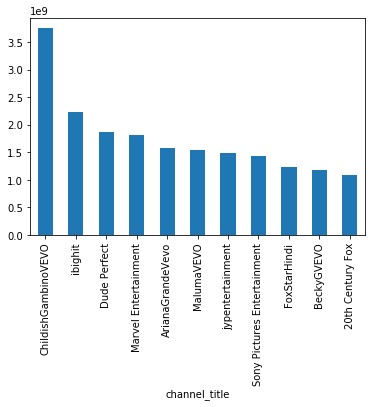

In [8]:
videos.groupby('channel_title')['views'].sum().sort_values(ascending=False)[0:11].plot(kind='bar')

In [158]:
#create date columns
videos['date'] = pd.to_datetime(videos['publish_time']).dt.date
videos['day'] = pd.to_datetime(videos['publish_time']).dt.day
videos['hour'] = pd.to_datetime(videos['publish_time']).dt.hour
videos['month'] = pd.to_datetime(videos['publish_time']).dt.month
videos['year'] = pd.to_datetime(videos['publish_time']).dt.year

#create keyword column from titles
videos['cleaned_title'] = [re.sub(r'[^\w\s]', '', x) for x in videos['title'].str.lower()]

#create bag of words
bow = []
for x in videos['cleaned_title']:
    words = x.split()
    bow += words
    
#lemmatize each word in the bag of words
lemmatizer = WordNetLemmatizer() 
lemmatize_bow = []
for word in bow:
    lemmatized = lemmatizer.lemmatize(word)
    lemmatize_bow.append(lemmatized)
    
#remove stopwords
stopword_list = stopwords.words('english')
final_bow = [word for word in lemmatize_bow if word not in stopword_list]
counts = Counter(final_bow)

title_counts = pd.DataFrame.from_dict(counts, orient='index').sort_values(by=0,ascending=False).reset_index().rename(columns={'index':'word',0:'count'})
title_counts.nlargest(15,columns='count')

,word,count
0,official,3981
1,video,2952
2,trailer,2258
3,2018,2238
4,ft,1301
5,v,1080
6,new,1005
7,2,909
8,2017,884
9,makeup,876


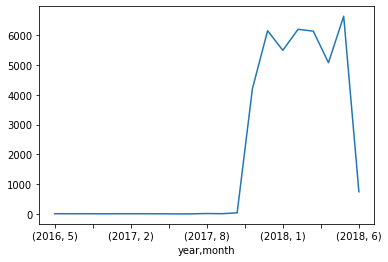

In [65]:
videos.groupby(['year','month'])['video_id'].count().loc[slice(2016, 2018)].plot()